In [1]:
import os

if (os.path.basename(os.getcwd()) == 'Notebooks'):
    os.chdir('..')
    
os.getcwd()

'c:\\Users\\sebastian\\SynologyDrive\\Studium\\10.Semester\\Wettbewerb\\project\\code\\KISMED'

In [56]:
#plt.rcParams.update(plt.rcParamsDefault)
import pandas as pd
import matplotlib.pyplot as plt
from ecgdetectors import Detectors
import scipy.fftpack
import seaborn as sns

from wettbewerb import load_references
from preprocessing.features import*
from preprocessing.preprocessing import*
from preprocessing.padding import *


# Time and Frequency Analysis

## Load the ECGs

In [3]:
ecg_leads, ecg_labels, fs, ecg_names = load_references(folder="data/training")

6000	 Dateien wurden geladen.


### Select only ECGs of the category Atrial Fibrilation (A) and Normal (N)

In [4]:
# get ids for ECGs from category AF and N
af_ids = np.where(np.array(ecg_labels)=='A')[0]
n_ids = np.where(np.array(ecg_labels)=='N')[0]

# get only ecgs from category AF and N
ecg_leads_n = np.array(ecg_leads, dtype=object)[n_ids]
ecg_leads_af = np.array(ecg_leads, dtype=object)[af_ids]

## Standard Deviation of the NN Intervall (SDNN)

### Extract Features

In [5]:
# compute RR-Interval std. for category AF and N (code from lib not in ms anymore as given in example...)
rri_std_n = rri_std(ecg_leads_n, fs)
rri_std_af = rri_std(ecg_leads_af, fs)

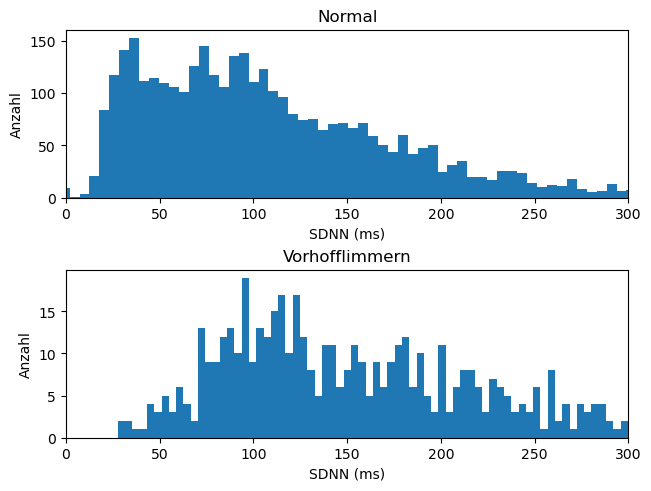

In [6]:
fig, axs = plt.subplots(2,1, constrained_layout=True)

axs[0].hist(np.array(rri_std_n)/fs*1000,2000)
axs[0].set_xlim([0, 300])
axs[0].set_title("Normal")
axs[0].set_xlabel("SDNN (ms)")
axs[0].set_ylabel("Anzahl")

axs[1].hist(np.array(rri_std_af)/fs*1000,300) 
axs[1].set_xlim([0, 300])
axs[1].set_title("Vorhofflimmern")
axs[1].set_xlabel("SDNN (ms)")
axs[1].set_ylabel("Anzahl")
plt.show()

### Inspect Feature

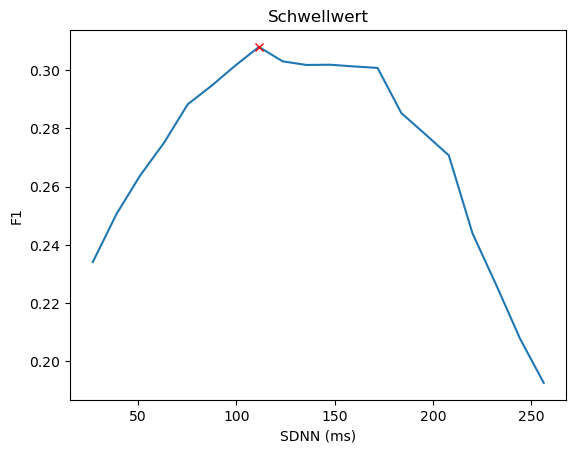

F1-score: 0.3079584775086505


In [7]:
sdnn_total = np.append(rri_std_n,rri_std_af) # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(sdnn_total,5)          # untere Schwelle
p95 = np.nanpercentile(sdnn_total,95)         # obere Schwelle
thresholds = np.linspace(p05, p95, num=20)    # Liste aller möglichen Schwellwerte
F1 = np.array([])
for th in thresholds:
  TP = np.sum(rri_std_af>=th)                  # Richtig Positiv
  TN = np.sum(rri_std_n<th)                 # Richtig Negativ
  FP = np.sum(rri_std_n>=th)                # Falsch Positiv
  FN = np.sum(rri_std_af<th)                   # Falsch Negativ
  F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores

th_opt=thresholds[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

fig, ax = plt.subplots()
ax.plot(thresholds/fs*1000,F1)
ax.plot(th_opt/fs*1000,F1[np.argmax(F1)],'xr')
ax.set_title("Schwellwert")
ax.set_xlabel("SDNN (ms)")
ax.set_ylabel("F1")
plt.show()

print('F1-score:', np.max(F1))

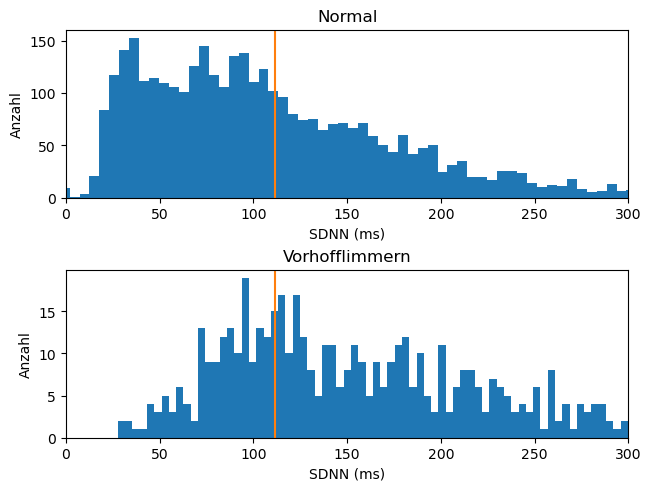

In [8]:
fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(np.array(rri_std_n)/fs*1000,2000)
axs[0].set_xlim([0, 300])
tmp = axs[0].get_ylim()
axs[0].plot([th_opt/fs*1000,th_opt/fs*1000],[0,10000])
axs[0].set_ylim(tmp)
axs[0].set_title("Normal")
axs[0].set_xlabel("SDNN (ms)")
axs[0].set_ylabel("Anzahl")

axs[1].hist(np.array(rri_std_af)/fs*1000,300)
axs[1].set_xlim([0, 300])
tmp = axs[1].get_ylim()
axs[1].plot([th_opt/fs*1000,th_opt/fs*1000],[0,10000])
axs[1].set_ylim(tmp)
axs[1].set_title("Vorhofflimmern")
axs[1].set_xlabel("SDNN (ms)")
axs[1].set_ylabel("Anzahl")

plt.show()

## Distribution of ECG durations

In [5]:
# collect the measurement durations
duration_normal = [len(eln)/fs for eln in ecg_leads_n]
duration_afib = [len(elaf)/fs for elaf in ecg_leads_af]

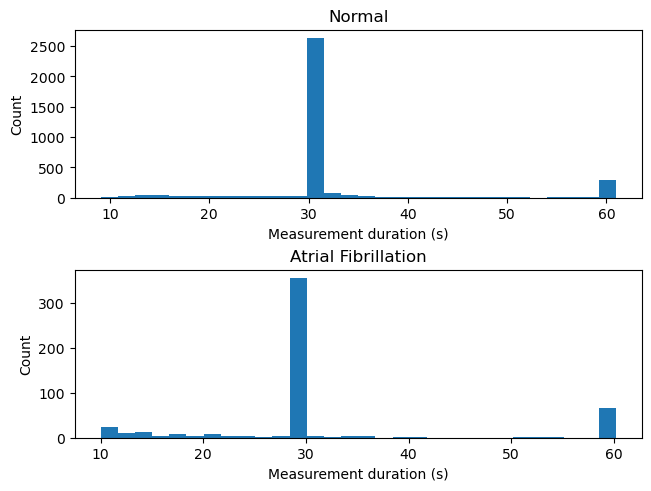

In [18]:
# plot a histogram with the measurement durations
nmbr_bins = 30

fig, axs = plt.subplots(2,1, constrained_layout=True)

axs[0].hist(duration_normal, nmbr_bins)
axs[0].set_xlim([0, 1.2*np.max(duration_normal)])
axs[0].set_title("Normal")
axs[0].set_xlabel("Measurement duration (s)")
axs[0].set_ylabel("Count")

axs[1].hist(duration_afib,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(duration_afib)])
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Measurement duration (s)")
axs[1].set_ylabel("Count")

plt.show()

## Distribution of R-Peaks per minute (RPM)

### Extract Feature

In [11]:
def compute_rpm(ecg_lead, detectors, fs):

    r_peaks = detectors.hamilton_detector(ecg_lead)
    meas_duration = len(ecg_lead)/fs
    rpm_normal = len(r_peaks)/meas_duration*60

    return rpm_normal

# # Test
# fs = 300
# detectors = Detectors(fs) 
# compute_rpm(ecg_leads_n[0], detectors, fs)

In [12]:
fs = 300
detectors = Detectors(fs) 

rpm_normal = [compute_rpm(eln, detectors, fs) for eln in ecg_leads_n]
rpm_afib = [compute_rpm(elaf, detectors, fs) for elaf in ecg_leads_af]

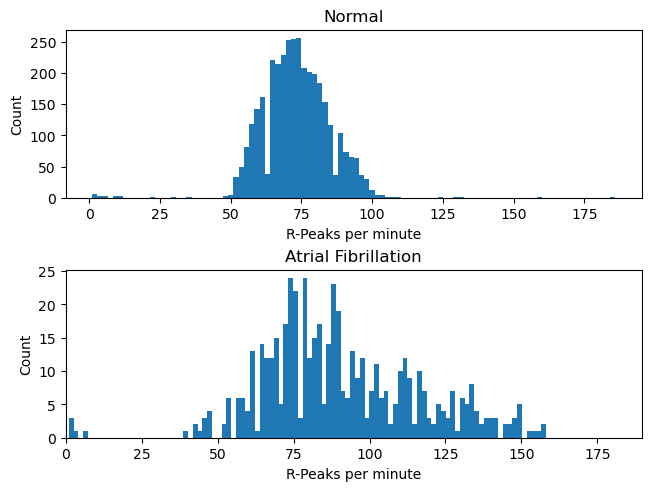

In [13]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(rpm_normal,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(rpm_normal)])
axs[0].set_title("Normal")
axs[0].set_xlabel("R-Peaks per minute")
axs[0].set_ylabel("Count")

axs[1].hist(rpm_afib,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(rpm_afib)])
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("R-Peaks per minute")
axs[1].set_ylabel("Count")

plt.show()

### Inspect Feature

0.4233128834355828


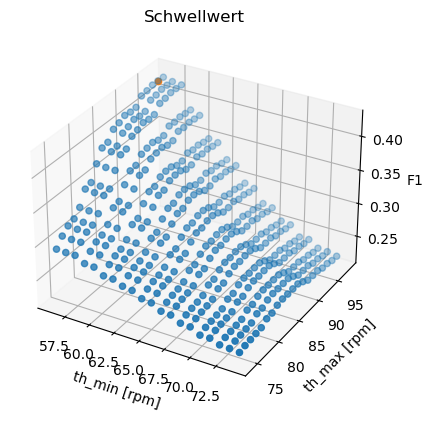

In [14]:
# Very simple approch to only show the possibilites to categorize...
rpm_total = np.append(rpm_normal,rpm_afib)      # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(rpm_total,5)             # untere Schwelle
p95 = np.nanpercentile(rpm_total,95)            # obere Schwelle
p50 = np.nanpercentile(rpm_total,50)            # threshold middle
thresholds_01 = np.linspace(p05, p50, num=20)   # Liste aller möglichen Schwellwerte
thresholds_02 = np.linspace(p50, p95, num=20)   # Liste aller möglichen Schwellwerte

th_tot01 = np.array([])
th_tot02 = np.array([])
F1 = np.array([])
for th01 in thresholds_01:                      # iterate over lower bound
  for th02 in thresholds_02:                    # iterate over upper bound
    TP = np.sum(np.logical_or(rpm_afib<=th01, rpm_afib>=th02))                  # Richtig Positiv
    TN = np.sum(np.logical_and(rpm_normal>th01, rpm_normal<th02))                 # Richtig Negativ
    FP = np.sum(np.logical_or(rpm_normal<=th01, rpm_normal>=th02))                # Falsch Positiv
    FN = np.sum(np.logical_and(rpm_afib>th01, rpm_afib<th02))                   # Falsch Negativ
    F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores
    
    th_tot01 = np.append(th_tot01, th01)
    th_tot02 = np.append(th_tot02, th02)

th_opt01= th_tot01[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score
th_opt02= th_tot02[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

# plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(th_tot01, th_tot02, F1)
ax.scatter(th_opt01, th_opt02, F1[np.argmax(F1)])
ax.set_title("Schwellwert")
ax.set_xlabel("th_min [rpm]")
ax.set_ylabel("th_max [rpm]")
ax.set_zlabel("F1")

print(np.max(F1))
plt.show()

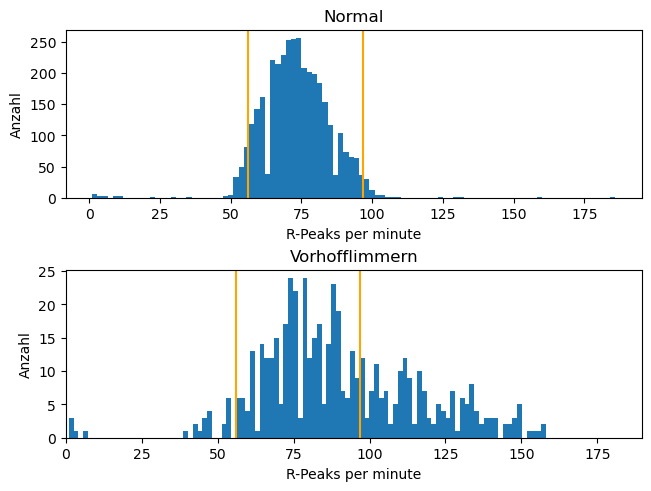

F1-score: 0.4233128834355828
Rule: RPM within range of: 56.0 to 96.74 is classified as Normal


In [15]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(rpm_normal,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(rpm_normal)])
tmp = axs[0].get_ylim()
axs[0].plot([th_opt01,th_opt01],[0,10000], color='orange')
axs[0].plot([th_opt02,th_opt02],[0,10000], color='orange')
axs[0].set_ylim(tmp)
axs[0].set_title("Normal")
axs[0].set_xlabel("R-Peaks per minute")
axs[0].set_ylabel("Anzahl")

axs[1].hist(rpm_afib,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(rpm_afib)])
tmp = axs[1].get_ylim()
axs[1].plot([th_opt01,th_opt01],[0,10000], color='orange')
axs[1].plot([th_opt02,th_opt02],[0,10000], color='orange')
axs[1].set_ylim(tmp)
axs[1].set_title("Vorhofflimmern")
axs[1].set_xlabel("R-Peaks per minute")
axs[1].set_ylabel("Anzahl")
plt.show()

print('F1-score:', np.max(F1))
print('Rule: RPM within range of: ' + str(th_opt01) + ' to ' + str(np.round(th_opt02,2)) + ' is classified as Normal')

# Frequency Domain

In [5]:
def compute_FFT(signal, fs=300):

    spectrum = scipy.fftpack.fft(signal)
    spectrum = 2/len(signal)*np.abs(spectrum[:len(signal)//2])
    freq = np.linspace(0.0, fs/2.0, len(signal)//2)  # want only too see the first half -> periodicity

    return (freq, spectrum)

# freq, spectrum = compute_FFT(ecg_leads_af[0])
# plt.plot(freq, spectrum)
# plt.show()

In [4]:
def compute_PSD(signal, fs=300):
    spectrum = np.fft.fft(signal)
    factor = 2.0/(len(spectrum)*len(spectrum))
    power = factor*(spectrum.real**2+spectrum.imag**2)
    freq = np.fft.fftfreq(len(signal), 1/fs)

    freq = freq[0:int(len(ecg_leads_af[0])/2)]
    power = power[0:int(len(ecg_leads_af[0])/2)]

    return (freq, power)

# freq, power = compute_PSD(ecg_leads_af[0], fs=300)
# plt.plot(freq, power)
# plt.show()

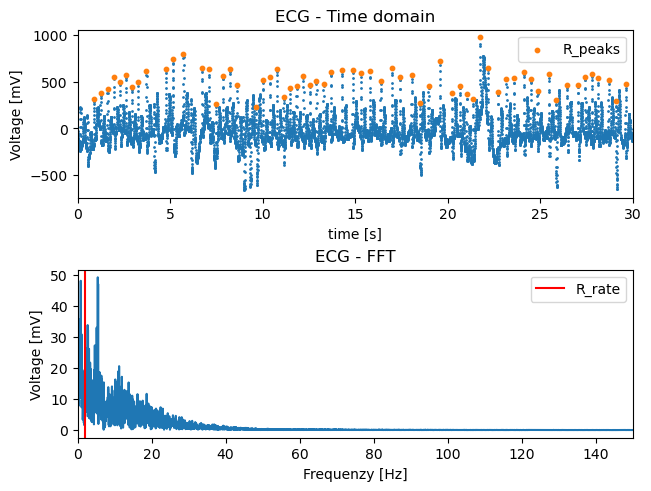

In [21]:
def plot_ecg(ecg_lead, detectors, time_span=np.NaN, freq_span=np.NaN, r_rate=False, fs=300):
    if np.isnan(time_span):  # in seconds
        time_span = (0, len(ecg_lead)/fs)
    if np.isnan(freq_span):
        freq_span = (0, fs/2.0)  # in Hz

    # FFT
    freq, spectrum = compute_FFT(ecg_lead, fs)

    # time 
    time_arr = np.linspace(0, len(ecg_lead)/fs, len(ecg_lead))

    # plot
    fig, axs = plt.subplots(2,1, constrained_layout=True)

    # time domain
    axs[0].scatter(time_arr, ecg_lead, s=1)
    axs[0].set_xlim(*time_span)
    axs[0].set_title("ECG - Time domain")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("Voltage [mV]")
   
    # frequency domain
    axs[1].plot(freq, spectrum)
    axs[1].set_xlim(*freq_span)
    axs[1].set_title("ECG - FFT")
    axs[1].set_xlabel("Frequenzy [Hz]")
    axs[1].set_ylabel("Voltage [mV]")

    # R-Peak rate
    if r_rate:
        r_peaks = detectors.engzee_detector(ecg_lead)  # TODO: algorithms vary in the resuls 
        r_rate = len(r_peaks)/(len(ecg_lead)/fs)
        axs[0].scatter(time_arr[r_peaks], ecg_lead[r_peaks], s=10, label='R_peaks')
        axs[1].axvline(x=r_rate, color='r', label='R_rate')        

        axs[0].legend(loc="best")
        axs[1].legend(loc="best")

    plt.show()

# Test method
fs = 300
detectors = Detectors(fs)
plot_ecg(ecg_leads_af[0], detectors, time_span=np.NaN, freq_span=np.NaN, r_rate=True, fs=300);
#plot_ecg(ecg_leads_af[0], detectors)

## Compute power in diffferent Frequency Bands

In [6]:
def compute_Band_Power(signal, lb, ub, psd=False, fs=300):

    if not psd:
        ecg_freq, ecg_abs = compute_FFT(signal, fs)
        mask = np.logical_and((ecg_freq>lb), (ecg_freq<=ub))
        band_power = np.sum(ecg_abs[mask]**2)/np.sum(ecg_abs**2)

    else:
        ecg_freq, ecg_abs = compute_PSD(signal, fs)
        mask = np.logical_and((ecg_freq>lb), (ecg_freq<=ub))
        band_power = np.sum(ecg_abs[mask])

    return band_power

In [7]:
freq_band = []

for eln in ecg_leads_n:
    low_freq = compute_Band_Power(eln, lb=0, ub=6)
    middle_freq = compute_Band_Power(eln, lb=6, ub=12)
    high_freq = compute_Band_Power(eln, lb=12, ub=20)
    extra_high_freq = compute_Band_Power(eln, lb=20, ub=30)

    freq_band.append([low_freq, middle_freq, high_freq, extra_high_freq, 1])

for elaf in ecg_leads_af:
    low_freq = compute_Band_Power(elaf, lb=0, ub=6)
    middle_freq = compute_Band_Power(elaf, lb=6, ub=12)
    high_freq = compute_Band_Power(elaf, lb=12, ub=20)
    extra_high_freq = compute_Band_Power(elaf, lb=20, ub=30)
    
    freq_band.append([low_freq, middle_freq, high_freq, extra_high_freq, 0])

# store all in one data frame
clmn_names = ['low_freq_power', 'middle_freq_power', 'high_freq_power', 'extra_high_freq_power', 'normal']
df_freq_band = pd.DataFrame(np.array(freq_band), columns=clmn_names)

In [21]:
# sns_plot = sns.pairplot(df_freq_band, hue='normal',
#                         height=2.5, corner=True, plot_kws=dict(alpha=0.1))
# plt.show()

### Low frequency band power (0-6Hz)

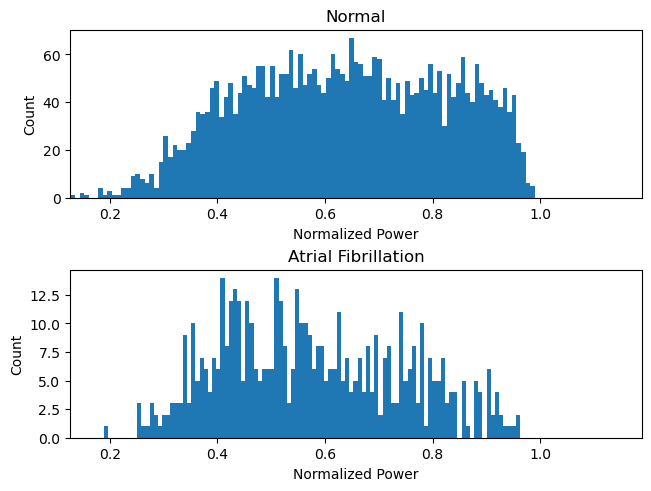

In [11]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

low_freq_n = df_freq_band[df_freq_band['normal']==1]['low_freq_power'].to_numpy()
axs[0].hist(low_freq_n, nmbr_bins)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

low_freq_af = df_freq_band[df_freq_band['normal']==0]['low_freq_power'].to_numpy()
axs[1].hist(low_freq_af, nmbr_bins)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*low_freq_n, *low_freq_af]), 1.2*np.max([*low_freq_n, *low_freq_af])))

plt.show()

### Middle frequency band power (6-12Hz)

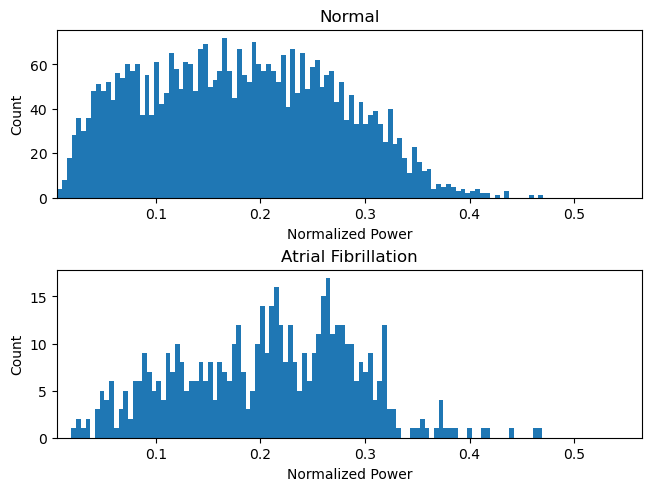

In [14]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

mid_freq_n = df_freq_band[df_freq_band['normal']==1]['middle_freq_power'].to_numpy()
axs[0].hist(mid_freq_n,nmbr_bins)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

mid_freq_af = df_freq_band[df_freq_band['normal']==0]['middle_freq_power'].to_numpy()
axs[1].hist(mid_freq_af,nmbr_bins)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*mid_freq_n, *mid_freq_af]), 1.2*np.max([*mid_freq_n, *mid_freq_af])))

plt.show()

### High frequency band power (12-20Hz)

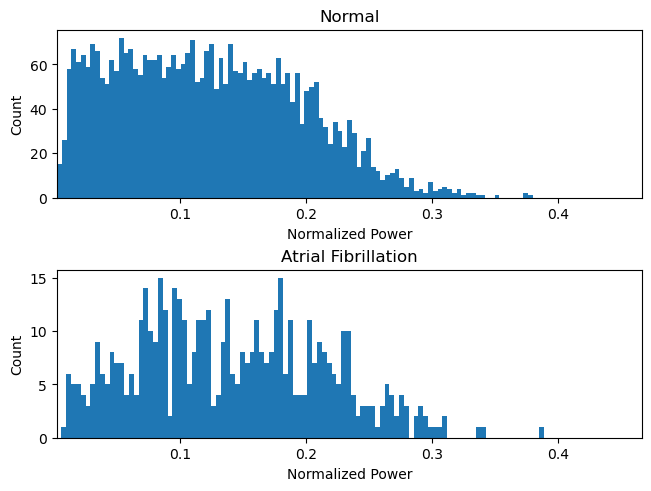

In [15]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

high_freq_n = df_freq_band[df_freq_band['normal']==1]['high_freq_power'].to_numpy()
axs[0].hist(high_freq_n,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(df_freq_band[df_freq_band['normal']==0]['high_freq_power'].to_numpy())])
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

high_freq_af = df_freq_band[df_freq_band['normal']==0]['high_freq_power'].to_numpy()
axs[1].hist(high_freq_af,nmbr_bins)
axs[1].set_xlim([0, 1.2*np.max(df_freq_band[df_freq_band['normal']==1]['high_freq_power'].to_numpy())])
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*high_freq_n, *high_freq_af]), 1.2*np.max([*high_freq_n, *high_freq_af])))

plt.show()

### Extra high frequency band power (20-30Hz)

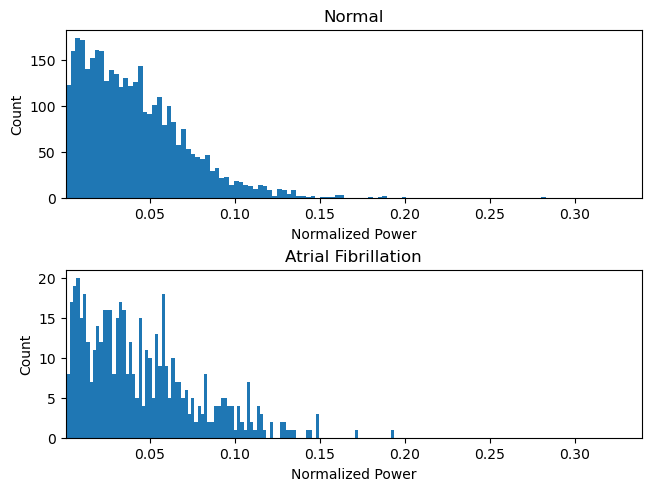

In [16]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

extra_high_freq_n = df_freq_band[df_freq_band['normal']==1]['extra_high_freq_power'].to_numpy()
axs[0].hist(extra_high_freq_n,nmbr_bins)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

extra_high_freq_af = df_freq_band[df_freq_band['normal']==0]['extra_high_freq_power'].to_numpy()
axs[1].hist(extra_high_freq_af,nmbr_bins)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*extra_high_freq_n, *extra_high_freq_af]), 1.2*np.max([*extra_high_freq_n, *extra_high_freq_af])))

plt.show()

# Inspection of single heartbeats

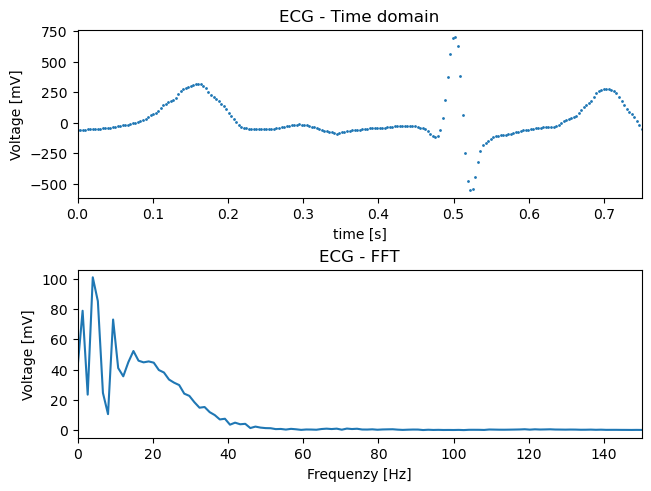

In [26]:
def plot_heartbeat(ecg_lead, detectors, beat_id=0, fs=300):
    beats = divide_heartbeats(ecg_lead, fs)
    plot_ecg(beats[beat_id], detectors, fs=fs)

# Test
detectors = Detectors(fs)
plot_heartbeat(ecg_leads_af[1], detectors, beat_id=5, fs=300)

### Inspecting heartbeats at fibrillation frequency band (3.8-8Hz)

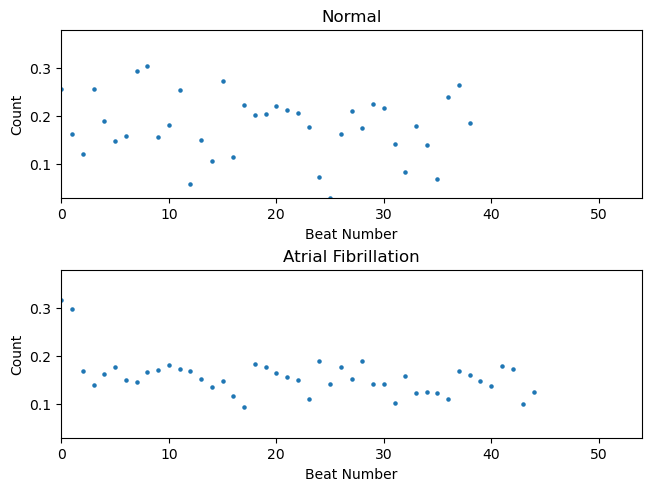

In [54]:
# Example
example_id = 15
psd = False

# plot
fig, axs = plt.subplots(2,1, constrained_layout=True)

# Normal ecg
beats = divide_heartbeats(ecg_leads_n[example_id], fs=fs)
power_band_n = []
for b in beats:
    fib_freq = compute_Band_Power(b, lb=3.8, ub=8, psd=psd)
    power_band_n.append(fib_freq)

axs[0].scatter(range(0, len(power_band_n)), power_band_n, s=5)
axs[0].set_title("Normal")
axs[0].set_xlabel("Beat Number")
axs[0].set_ylabel("Normalized Power")


# AF ecg
beats = divide_heartbeats(ecg_leads_af[example_id], fs=fs)
power_band_af = []
for b in beats:
    fib_freq = compute_Band_Power(b, lb=3.8, ub=8, psd=psd)
    power_band_af.append(fib_freq)

axs[1].scatter(range(len(power_band_af)), power_band_af, s=5)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Beat Number")
axs[1].set_ylabel("Normalized Power")

plt.setp(axs, xlim=(0, 1.2*np.max([len(power_band_n), len(power_band_af)])), ylim=(np.min([*power_band_n, *power_band_af]), 1.2*np.max([*power_band_n, *power_band_af])))

plt.show()

### Computing std. of the normalized power for each beat on each ECG 

In [68]:
ecg_leads_n_beats_std = []
for ecg in ecg_leads_n:
    inv_tmp = invert2(ecg)
    beats = divide_heartbeats(inv_tmp, fs)
    if len(beats)!=0:
        power_band = []
        for b in beats:
            low_freq = compute_Band_Power(b, lb=3.8, ub=8)
            power_band.append(low_freq)
        ecg_leads_n_beats_std.append(np.std(power_band))

ecg_leads_af_beats_std = []
for ecg in ecg_leads_af:
    inv_tmp = invert2(ecg)
    beats = divide_heartbeats(inv_tmp, fs)
    if len(beats)!=0:
        power_band = []
        for b in beats:
            low_freq = compute_Band_Power(b, lb=3.8, ub=8)
            power_band.append(low_freq)
        ecg_leads_af_beats_std.append(np.std(power_band))

c:\Users\sebastian\SynologyDrive\Studium\10.Semester\Wettbewerb\project\code\KISMED\preprocessing\preprocessing.py:58: RuntimeWarning: Mean of empty slice.
  orig_peaks_mean = orig_sinal_peaks.mean()
c:\Users\sebastian\anaconda3\envs\AFDet\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No R-Peaks found in signal!


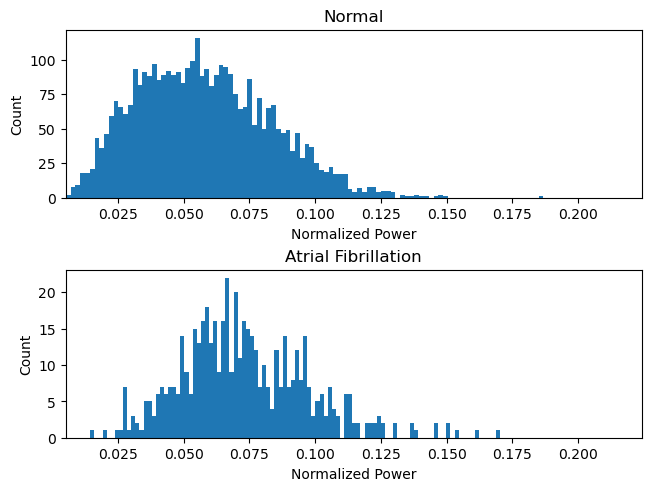

In [69]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)

axs[0].hist(ecg_leads_n_beats_std,nmbr_bins)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_std,nmbr_bins)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_std, *ecg_leads_af_beats_std]), 1.2*np.max([*ecg_leads_n_beats_std, *ecg_leads_af_beats_std])))

plt.show()

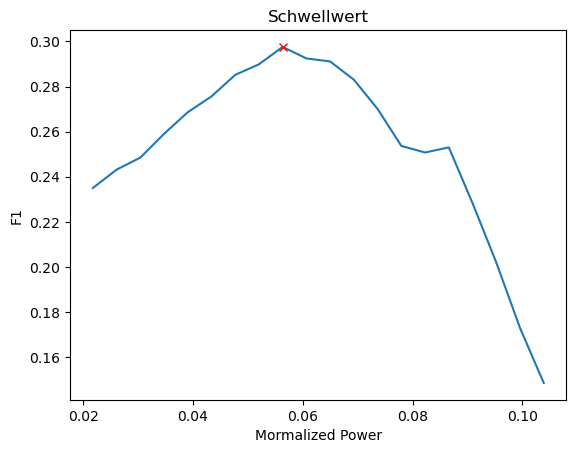

F1-score: 0.29757009345794394


In [70]:
beats_max_total = np.append(ecg_leads_n_beats_std,ecg_leads_af_beats_std) # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(beats_max_total,5)          # untere Schwelle
p95 = np.nanpercentile(beats_max_total,95)         # obere Schwelle
thresholds = np.linspace(p05, p95, num=20)    # Liste aller möglichen Schwellwerte
F1 = np.array([])
for th in thresholds:
  TP = np.sum(ecg_leads_af_beats_std>=th)                  # Richtig Positiv
  TN = np.sum(ecg_leads_n_beats_std<th)                 # Richtig Negativ
  FP = np.sum(ecg_leads_n_beats_std>=th)                # Falsch Positiv
  FN = np.sum(ecg_leads_af_beats_std<th)                   # Falsch Negativ
  F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores

th_opt=thresholds[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

fig, ax = plt.subplots()
ax.plot(thresholds,F1)
ax.plot(th_opt,F1[np.argmax(F1)],'xr')
ax.set_title("Schwellwert")
ax.set_xlabel("Mormalized Power")
ax.set_ylabel("F1")
plt.show()

print('F1-score:', np.max(F1))

### Compute max. normalized power of a heartbeat in each ECG

In [71]:
ecg_leads_n_beats_max = []
for ecg in ecg_leads_n:
    inv_tmp = invert2(ecg)
    beats = divide_heartbeats(inv_tmp, fs)
    if len(beats)!=0:
        power_band = []
        for b in beats:
            low_freq = compute_Band_Power(b, lb=3.8, ub=8)
            power_band.append(low_freq)
        ecg_leads_n_beats_max.append(np.max(power_band))

ecg_leads_af_beats_max = []
for ecg in ecg_leads_af:
    inv_tmp = invert2(ecg)
    beats = divide_heartbeats(inv_tmp, fs)
    if len(beats)!=0:
        power_band = []
        for b in beats:
            low_freq = compute_Band_Power(b, lb=3.8, ub=8)
            power_band.append(low_freq)
        ecg_leads_af_beats_max.append(np.max(power_band))

c:\Users\sebastian\SynologyDrive\Studium\10.Semester\Wettbewerb\project\code\KISMED\preprocessing\preprocessing.py:58: RuntimeWarning: Mean of empty slice.
  orig_peaks_mean = orig_sinal_peaks.mean()
c:\Users\sebastian\anaconda3\envs\AFDet\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No R-Peaks found in signal!


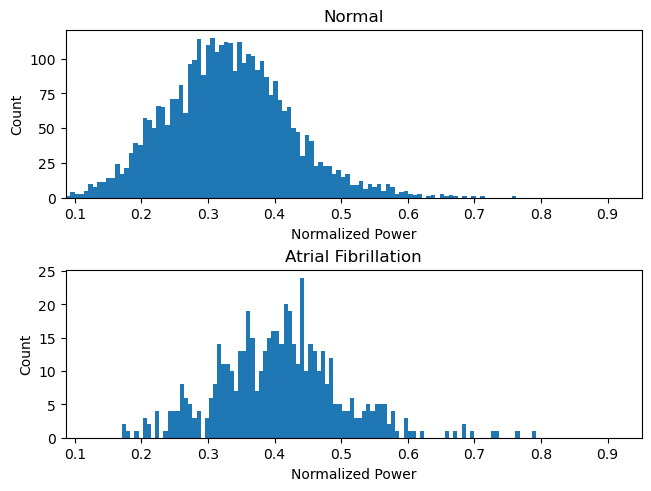

In [72]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(ecg_leads_n_beats_max,nmbr_bins)
axs[0].set_xlim([0, 0.8])
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_max,nmbr_bins)
axs[1].set_xlim([0, 0.8])
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")


plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max]), 1.2*np.max([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max])))

plt.show()

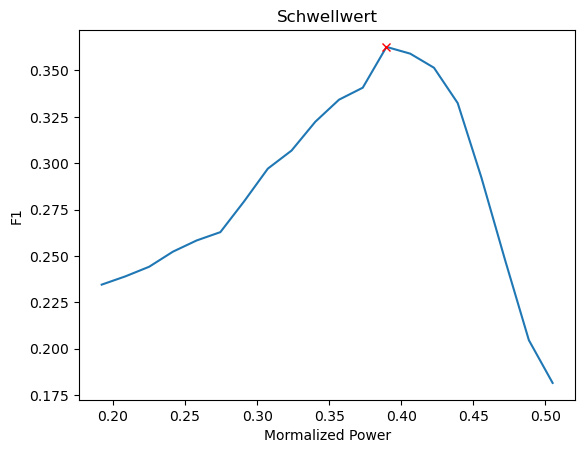

F1-score: 0.3626698168930892


In [73]:
beats_max_total = np.append(ecg_leads_n_beats_max,ecg_leads_af_beats_max) # Kombination der beiden SDNN-Listen
p05 = np.nanpercentile(beats_max_total,5)          # untere Schwelle
p95 = np.nanpercentile(beats_max_total,95)         # obere Schwelle
thresholds = np.linspace(p05, p95, num=20)    # Liste aller möglichen Schwellwerte
F1 = np.array([])
for th in thresholds:
  TP = np.sum(ecg_leads_af_beats_max>=th)                  # Richtig Positiv
  TN = np.sum(ecg_leads_n_beats_max<th)                 # Richtig Negativ
  FP = np.sum(ecg_leads_n_beats_max>=th)                # Falsch Positiv
  FN = np.sum(ecg_leads_af_beats_max<th)                   # Falsch Negativ
  F1 = np.append(F1, TP / (TP + 1/2*(FP+FN))) # Berechnung des F1-Scores

th_opt=thresholds[np.argmax(F1)]              # Bestimmung des Schwellwertes mit dem höchsten F1-Score

fig, ax = plt.subplots()
ax.plot(thresholds,F1)
ax.plot(th_opt,F1[np.argmax(F1)],'xr')
ax.set_title("Schwellwert")
ax.set_xlabel("Mormalized Power")
ax.set_ylabel("F1")
plt.show()

print('F1-score:', np.max(F1))

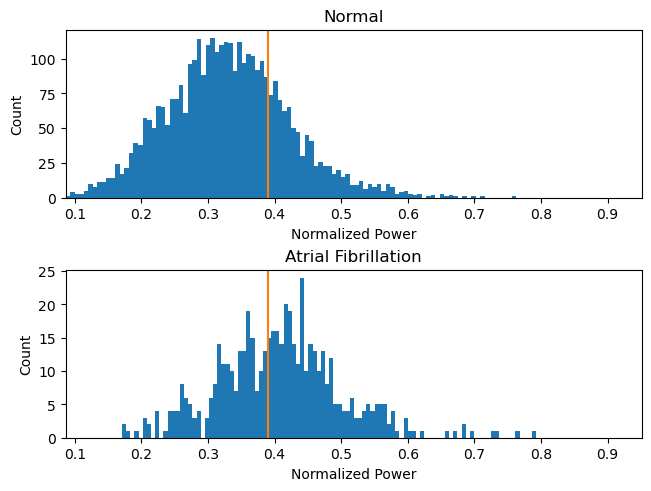

In [76]:
nmbr_bins = 100

fig, axs = plt.subplots(2,1, constrained_layout=True)
axs[0].hist(ecg_leads_n_beats_max,nmbr_bins)
tmp_y = axs[0].get_ylim()
axs[0].plot([th_opt,th_opt],[0,10000])
axs[0].set_ylim(tmp_y)
axs[0].set_title("Normal")
axs[0].set_xlabel("Normalized Power")
axs[0].set_ylabel("Count")

axs[1].hist(ecg_leads_af_beats_max,nmbr_bins)
tmp_y = axs[1].get_ylim()
axs[1].plot([th_opt,th_opt],[0,10000])
axs[1].set_ylim(tmp_y)
axs[1].set_title("Atrial Fibrillation")
axs[1].set_xlabel("Normalized Power")
axs[1].set_ylabel("Count")

plt.setp(axs, xlim=(np.min([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max]), 1.2*np.max([*ecg_leads_n_beats_max, *ecg_leads_af_beats_max])))

plt.show()